# EDA 

### Importing Libraries

In [91]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import re


### Importing Datasets 

In [92]:
opioids = pd.read_csv('opioids.csv')
overdoses = pd.read_csv('overdoses.csv')
prescribers = pd.read_csv('prescriber-info.csv')
prescribers_clean = pd.read_csv('prescribers_clean.csv')

In [93]:
# Explore drug data 

opioids.head()

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


In [94]:
opioids.shape

(113, 2)

#### The opioids dataset is drug names with coorelated generic name of drug. 

In [95]:
overdoses.shape

(50, 4)

#### Exploring Overdose Dataset 

In [97]:
overdoses.head()

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ
3,Arkansas,"2,959,373",356,AR
4,California,"38,332,521","4,521",CA


In [98]:
overdoses.shape

(50, 4)

In [99]:
overdoses.dtypes

State         object
Population    object
Deaths        object
Abbrev        object
dtype: object

In [100]:
# Going to change some of the objects into floats so we can properly see which states have more deaths than others 

overdoses['Deaths'] = overdoses['Deaths'].apply(lambda x: float(re.sub(',', '', x)))
overdoses['Population'] = overdoses['Population'].apply(lambda x: float(re.sub(',', '', x)))

In [101]:
# Checking the dataframe information 

overdoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
State         50 non-null object
Population    50 non-null float64
Deaths        50 non-null float64
Abbrev        50 non-null object
dtypes: float64(2), object(2)
memory usage: 1.6+ KB


In [102]:
# Checking out which states have the most amount of deaths from ODs 

overdoses.sort_values('Deaths', ascending=False).head()

,State,Population,Deaths,Abbrev
4,California,38332521.0,4521.0,CA
34,Ohio,11570808.0,2744.0,OH
37,Pennsylvania,12773801.0,2732.0,PA
8,Florida,19552860.0,2634.0,FL
42,Texas,26448193.0,2601.0,TX


#### Highest overdose related deaths tend to be California, Ohio, Pennsylvania, Florida, Texas

In [103]:
# This dataset is clean with no null values. Will do some plotting later to show state/death correlations 
overdoses.isnull().sum() 

State         0
Population    0
Deaths        0
Abbrev        0
dtype: int64

In [104]:
# Bringing in main dataset 

prescribers.head() 

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


NPI – unique National Provider Identifier number

Gender - (M/F)

State - U.S. State by abbreviation

Credentials - set of initials indicative of medical degree

Specialty - description of type of medicinal practice

A long list of drugs with numeric values indicating the total number of prescriptions written for the year by that 
individual

Opioid.Prescriber - a boolean label indicating whether or not that individual prescribed opiate drugs more than 10 times in the year 

In [105]:
prescribers.shape

(25000, 256)

In [106]:
prescribers.columns

Index(['NPI', 'Gender', 'State', 'Credentials', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN.CODEINE', 'ACYCLOVIR', 'ADVAIR.DISKUS', 'AGGRENOX',
       ...
       'VERAPAMIL.ER', 'VESICARE', 'VOLTAREN', 'VYTORIN', 'WARFARIN.SODIUM',
       'XARELTO', 'ZETIA', 'ZIPRASIDONE.HCL', 'ZOLPIDEM.TARTRATE',
       'Opioid.Prescriber'],
      dtype='object', length=256)

In [107]:
prescribers # Exploring the dataframe, specifically the NaN values in the Credentials column

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1
5,1548580897,M,PA,DO,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1437192002,M,NH,MD,Family Practice,0,0,0,25,0,...,0,0,0,0,80,0,16,0,38,1
7,1407113988,F,PA,"RN, MSN, ANP-BC",Nurse Practitioner,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1023260569,M,TX,O.D.,Optometry,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1821106832,F,WI,MD,Internal Medicine,0,0,0,11,0,...,0,0,0,0,56,0,20,0,0,1


In [108]:
prescribers.isnull().sum()

NPI                                 0
Gender                              0
State                               0
Credentials                       763
Specialty                           0
ABILIFY                             0
ACETAMINOPHEN.CODEINE               0
ACYCLOVIR                           0
ADVAIR.DISKUS                       0
AGGRENOX                            0
ALENDRONATE.SODIUM                  0
ALLOPURINOL                         0
ALPRAZOLAM                          0
AMIODARONE.HCL                      0
AMITRIPTYLINE.HCL                   0
AMLODIPINE.BESYLATE                 0
AMLODIPINE.BESYLATE.BENAZEPRIL      0
AMOXICILLIN                         0
AMOX.TR.POTASSIUM.CLAVULANATE       0
AMPHETAMINE.SALT.COMBO              0
ATENOLOL                            0
ATORVASTATIN.CALCIUM                0
AVODART                             0
AZITHROMYCIN                        0
BACLOFEN                            0
BD.ULTRA.FINE.PEN.NEEDLE            0
BENAZEPRIL.H

In [109]:
prescribers['Credentials'].head() # Exploring Credentials column

0     DDS
1      MD
2    M.D.
3      MD
4    M.D.
Name: Credentials, dtype: object

In [110]:
prescribers['Credentials'] # Still looking to see where NaN values are

0                    DDS
1                     MD
2                   M.D.
3                     MD
4                   M.D.
5                     DO
6                     MD
7        RN, MSN, ANP-BC
8                   O.D.
9                     MD
10                  M.D.
11                    MD
12                    MD
13                    MD
14                    MD
15                  M.D.
16                  M.D.
17                   NaN
18                  M.D.
19                D.D.S.
20                  M.D.
21                  M.D.
22                  ACNP
23                   DPM
24                   PAC
25              A.R.N.P.
26                  M.D.
27                    MD
28                    MD
29                   DDS
              ...       
24970                 MD
24971               M.D.
24972               M.D.
24973               M.D.
24974               M.D.
24975               CRNP
24976             D.D.S.
24977               M.D.
24978             D.D.S.


In [111]:
# Dropping NaN values 
prescribers.Credentials.value_counts()

MD                      7034
M.D.                    6772
DDS                     1145
D.O.                     866
PA-C                     845
D.D.S.                   717
DO                       549
NP                       469
DMD                      449
PA                       437
O.D.                     353
FNP                      262
ARNP                     256
DPM                      247
M.D                      243
D.M.D.                   234
OD                       175
P.A.                     168
CRNP                     150
APRN                     134
N.P.                     105
PAC                       98
D.P.M.                    98
CNP                       86
D.D.S                     85
NP-C                      84
FNP-C                     70
APN                       66
FNP-BC                    56
P.A.-C                    52
                        ... 
RN,BSN,APN-C               1
JAMES KIM                  1
PA-C, ND, MSOM, MS         1
RN, MS, FNP-C 

In [112]:
# Dummy gender, could drop it, seems uncessary 

prescribers = pd.get_dummies(prescribers, columns=['Gender'], drop_first=True)

In [113]:
# Drop NaNs 

prescribers.dropna(how='any', inplace=True)

In [114]:
# Those null values didn't mean anything because they could not prescribe anything anyway, so I dropped them. 

prescribers.isnull().sum().head()

NPI            0
State          0
Credentials    0
Specialty      0
ABILIFY        0
dtype: int64

### Continuing Cleaning 

In [115]:
len(prescribers['Specialty'].unique())

108

In [116]:
specialty = pd.DataFrame(prescribers.groupby(['Specialty']).count()['NPI']).sort_values('NPI')

In [117]:
specialty.loc[specialty['NPI']< 40].shape

(63, 1)

#### There are 108 unique Specialities, and 63 of them have a length of less than 40, so adjusting those so they can be a bit more balanced and sorted into specific specialities

In [118]:
otherSpecialty = list(specialty.loc[specialty['NPI']<40].index)

#### Splitting up these specialities between two groups : other and surgery 

In [119]:
prescribers.loc[prescribers['Specialty'].isin(otherSpecialty), 'Specialty'] = prescribers.loc[prescribers['Specialty'].isin(otherSpecialty), 'Specialty'].apply(lambda x: 'Surgery' if 'Surgery' in list(x.split( )) else 'Other')

#### Checking out the Credentials column 

In [120]:
Credentials = pd.DataFrame(prescribers.groupby(['Credentials']).count()['NPI']).reset_index(False)

In [121]:
Credentials[Credentials['NPI'] < 20]

,Credentials,NPI
0,(DMD),1
1,A.N.P.,6
2,A.P.N.,4
3,A.P.R.N.,5
4,A.P.R.N. N.P.,1
5,"A.P.R.N., B.C.",1
6,"A.P.R.N., W.H.N.P.",1
7,A.R.N.P,2
8,A.R.N.P.,15
9,"A.R.N.P. , PMHNP-BC",1


#### There are a lot of unique credentials and they will not be useful in my model so I will be dropping this column. NPI is also being dropped, as it is just another index. 

In [123]:
# Does not need to be run again

#prescribers_clean = pd.get_dummies(prescribers_clean, columns = ['Specialty', 'NPI'], drop_first = True)

Map of the US with the amount of opioid overdose deaths per state 

In [124]:
opioids_listed = list(re.sub(r'[-\s]','.',x) for x in opioids.values[:,0])
prescribed_opioids = list(set(opioids_listed) & set(prescribers.columns))

for i,drug in enumerate(prescribed_opioids):
    print (i+1,drug)

1 TRAMADOL.HCL
2 MORPHINE.SULFATE
3 OXYCONTIN
4 ACETAMINOPHEN.CODEINE
5 HYDROCODONE.ACETAMINOPHEN
6 MORPHINE.SULFATE.ER
7 OXYCODONE.ACETAMINOPHEN
8 OXYCODONE.HCL
9 FENTANYL
10 HYDROMORPHONE.HCL
11 METHADONE.HCL


#### The Prescribers main dataframe has 250 drugs listed. Of the 250 drugs, 11 are opioids. 

In [83]:
# Calculate the total amount of opioid prescribers in our list 

total_opioids_prescribers = (float(prescribers['Opioid.Prescriber'].sum()) * 100 / prescribers.shape[0])

total_opioids_prescribers

58.752

### 59% of prescribers are opioid prescribers 

### Visualizing prescriptions by speciality of the presciber 

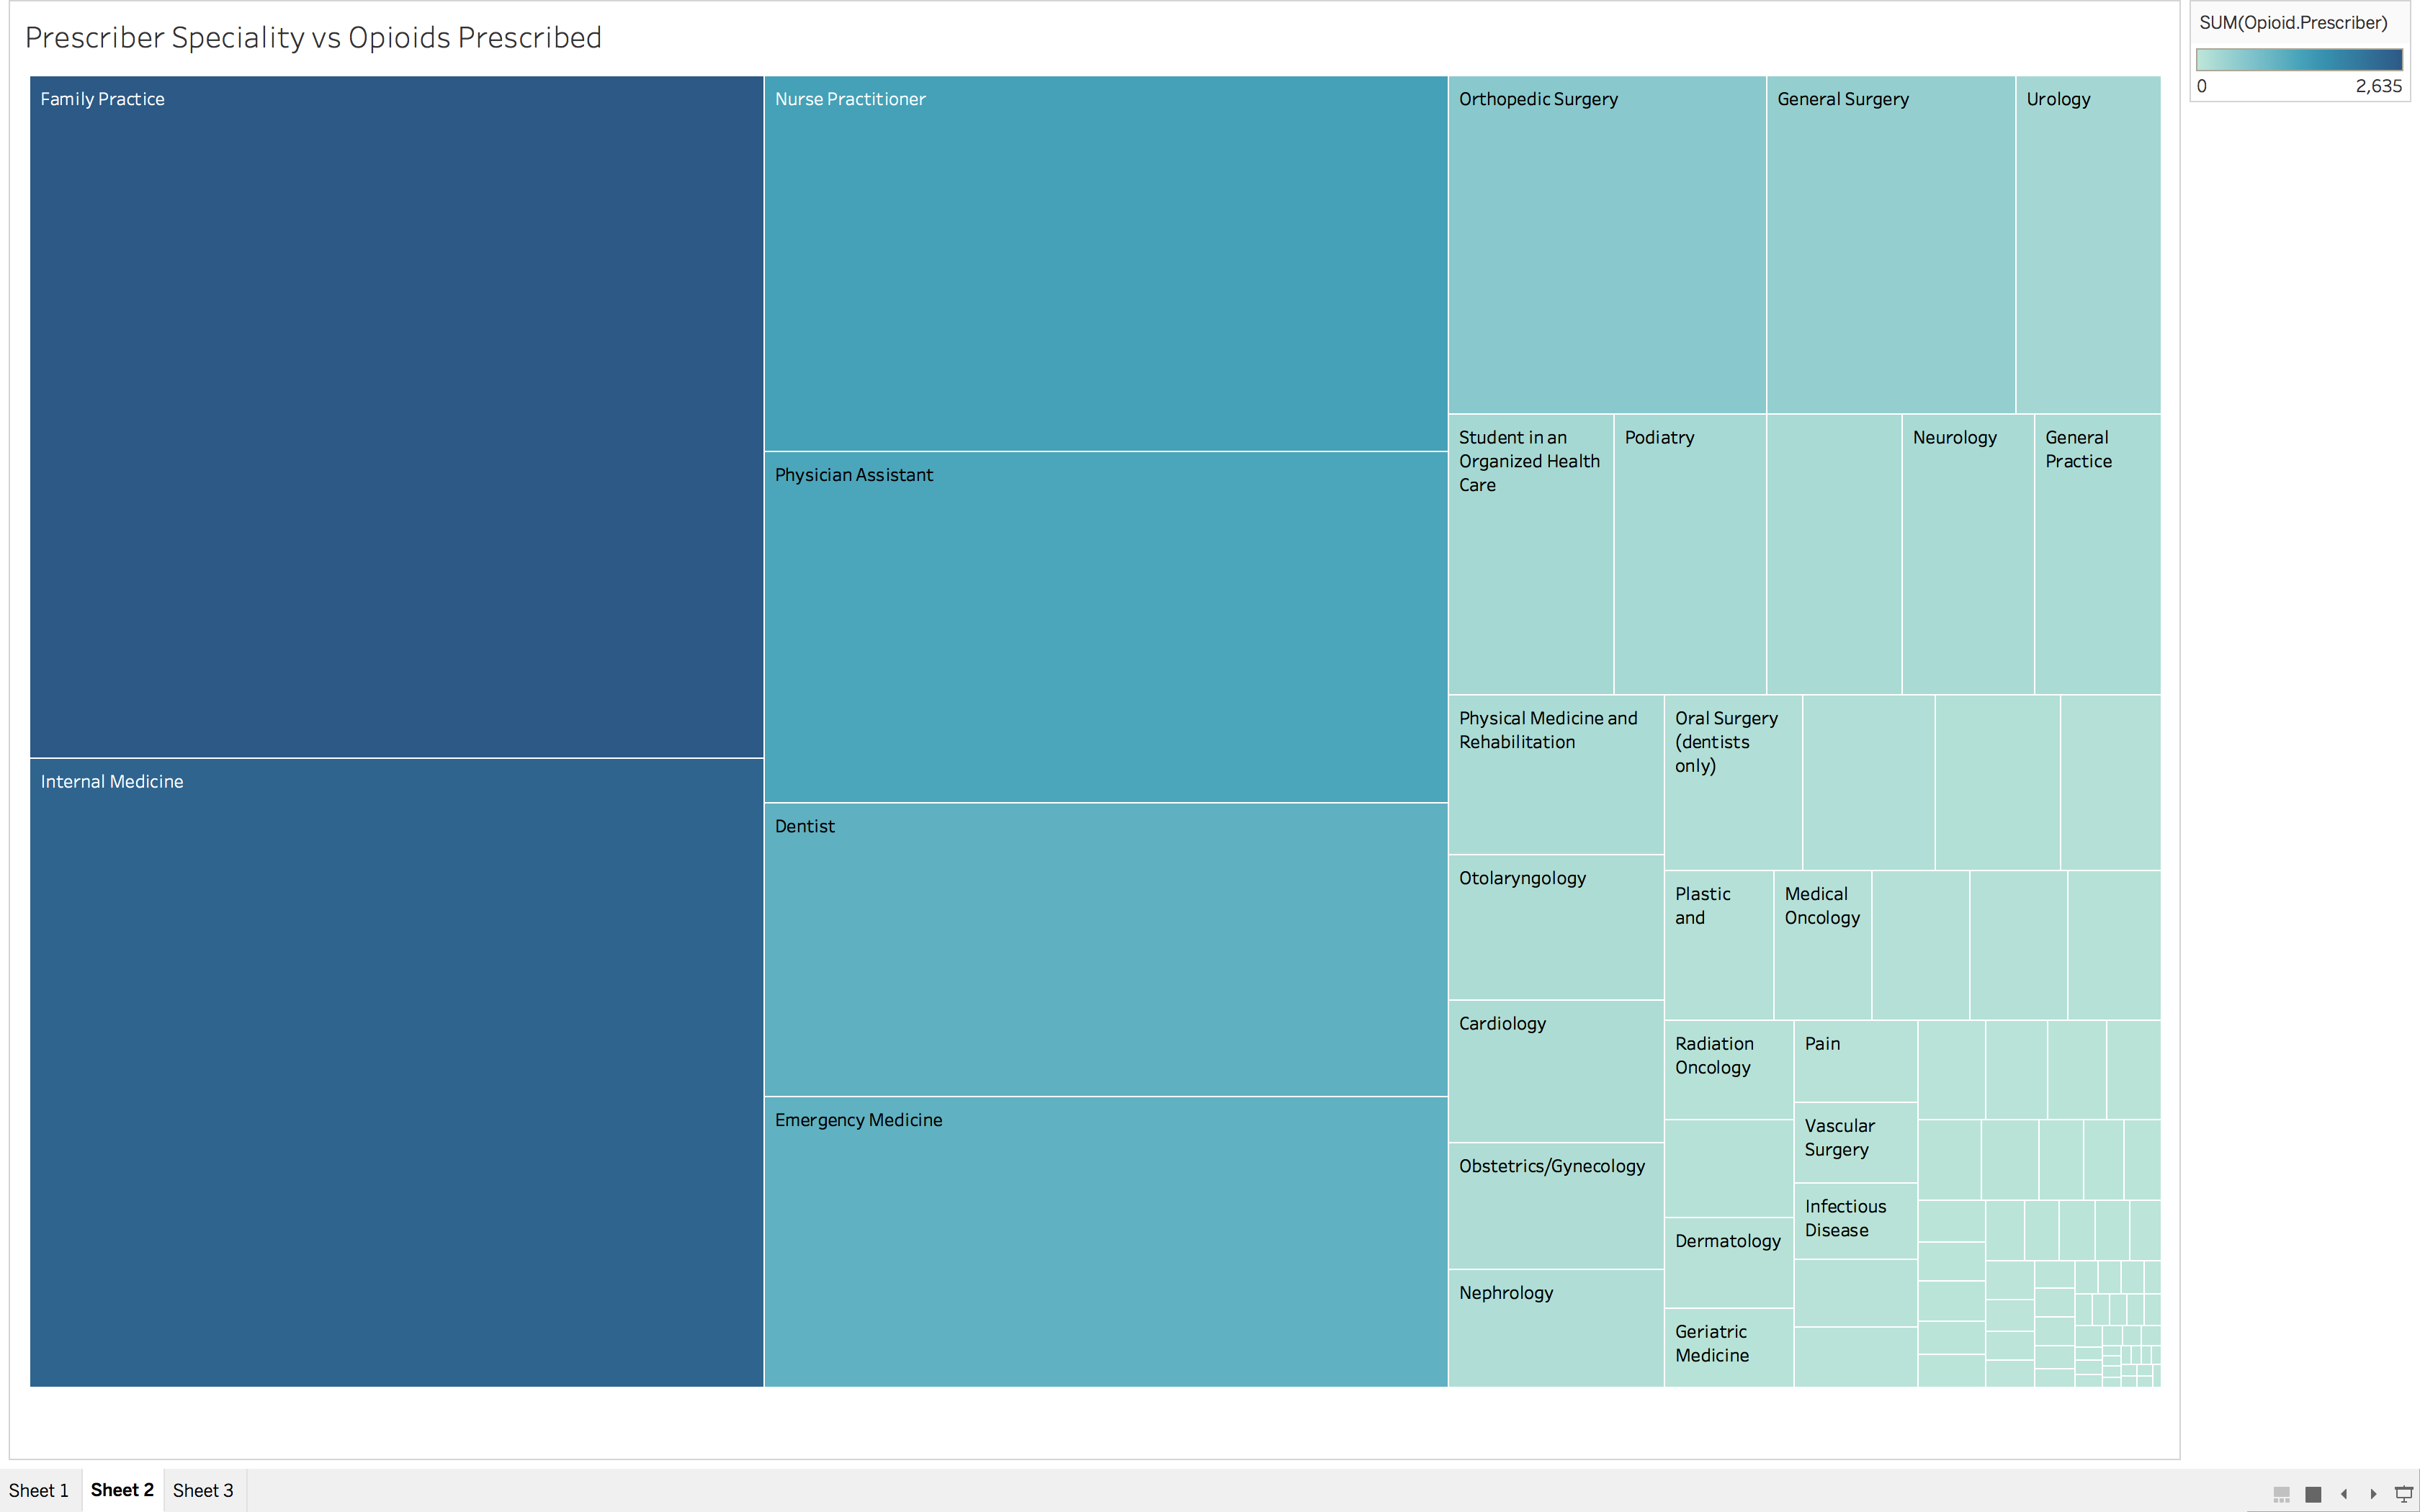

#### Two biggest Specialities that prescribe opioids are Family Practice and Internal Medicine (Very surprising, actually) 
#### Maybe because Family Practice/Internal Medicine are the typical doctors you see first 

In [130]:
# Adding deaths by state 

prescribers_clean = prescribers_clean.merge(overdoses[['Abbrev', 'Deaths']], left_on = 'State', right_on = 'Abbrev')

In [134]:
# DO NOT NEED TO RUN AGAIN / Cleaning up the state abbreviation/death columns, I had too many


#prescribers_clean.drop('Deaths_y', axis=1, inplace=True)
#prescribers_clean.drop('Abbrev_y', axis=1, inplace=True)
#prescribers_clean.drop('Abbrev_x', axis=1, inplace=True)
#prescribers_clean.drop('Deaths_x', axis=1, inplace=True)

In [150]:
# Do not need to run again
#prescribers_clean.drop('Unnamed: 0', axis=1, inplace=True)
#prescribers_clean.drop('Unnamed: 0.1', axis=1, inplace=True)

In [151]:
prescribers_clean.head()

,State,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,total_opioids,total_prescriptions,Abbrev,Deaths
0,TX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,17,47,TX,2601.0
1,TX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,144,TX,2601.0
2,TX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,17,35,TX,2601.0
3,TX,0,0,16,0,0,0,0,22,0,...,40,54,0,0,12,1,155,890,TX,2601.0
4,TX,0,23,0,0,0,0,0,12,0,...,0,0,0,0,0,1,132,1332,TX,2601.0


In [136]:
print(prescribers_clean.total_opioids.sum())
print(prescribers_clean.total_prescriptions.sum())

2095269
35249198


In [137]:
33910684 / 2108500 # so about 16% of total prescriptions are opioids only 

16.082847521935026

#### 16% of total prescriptions are opioids 

### Total opioid precrptions vs total prescriptions per state

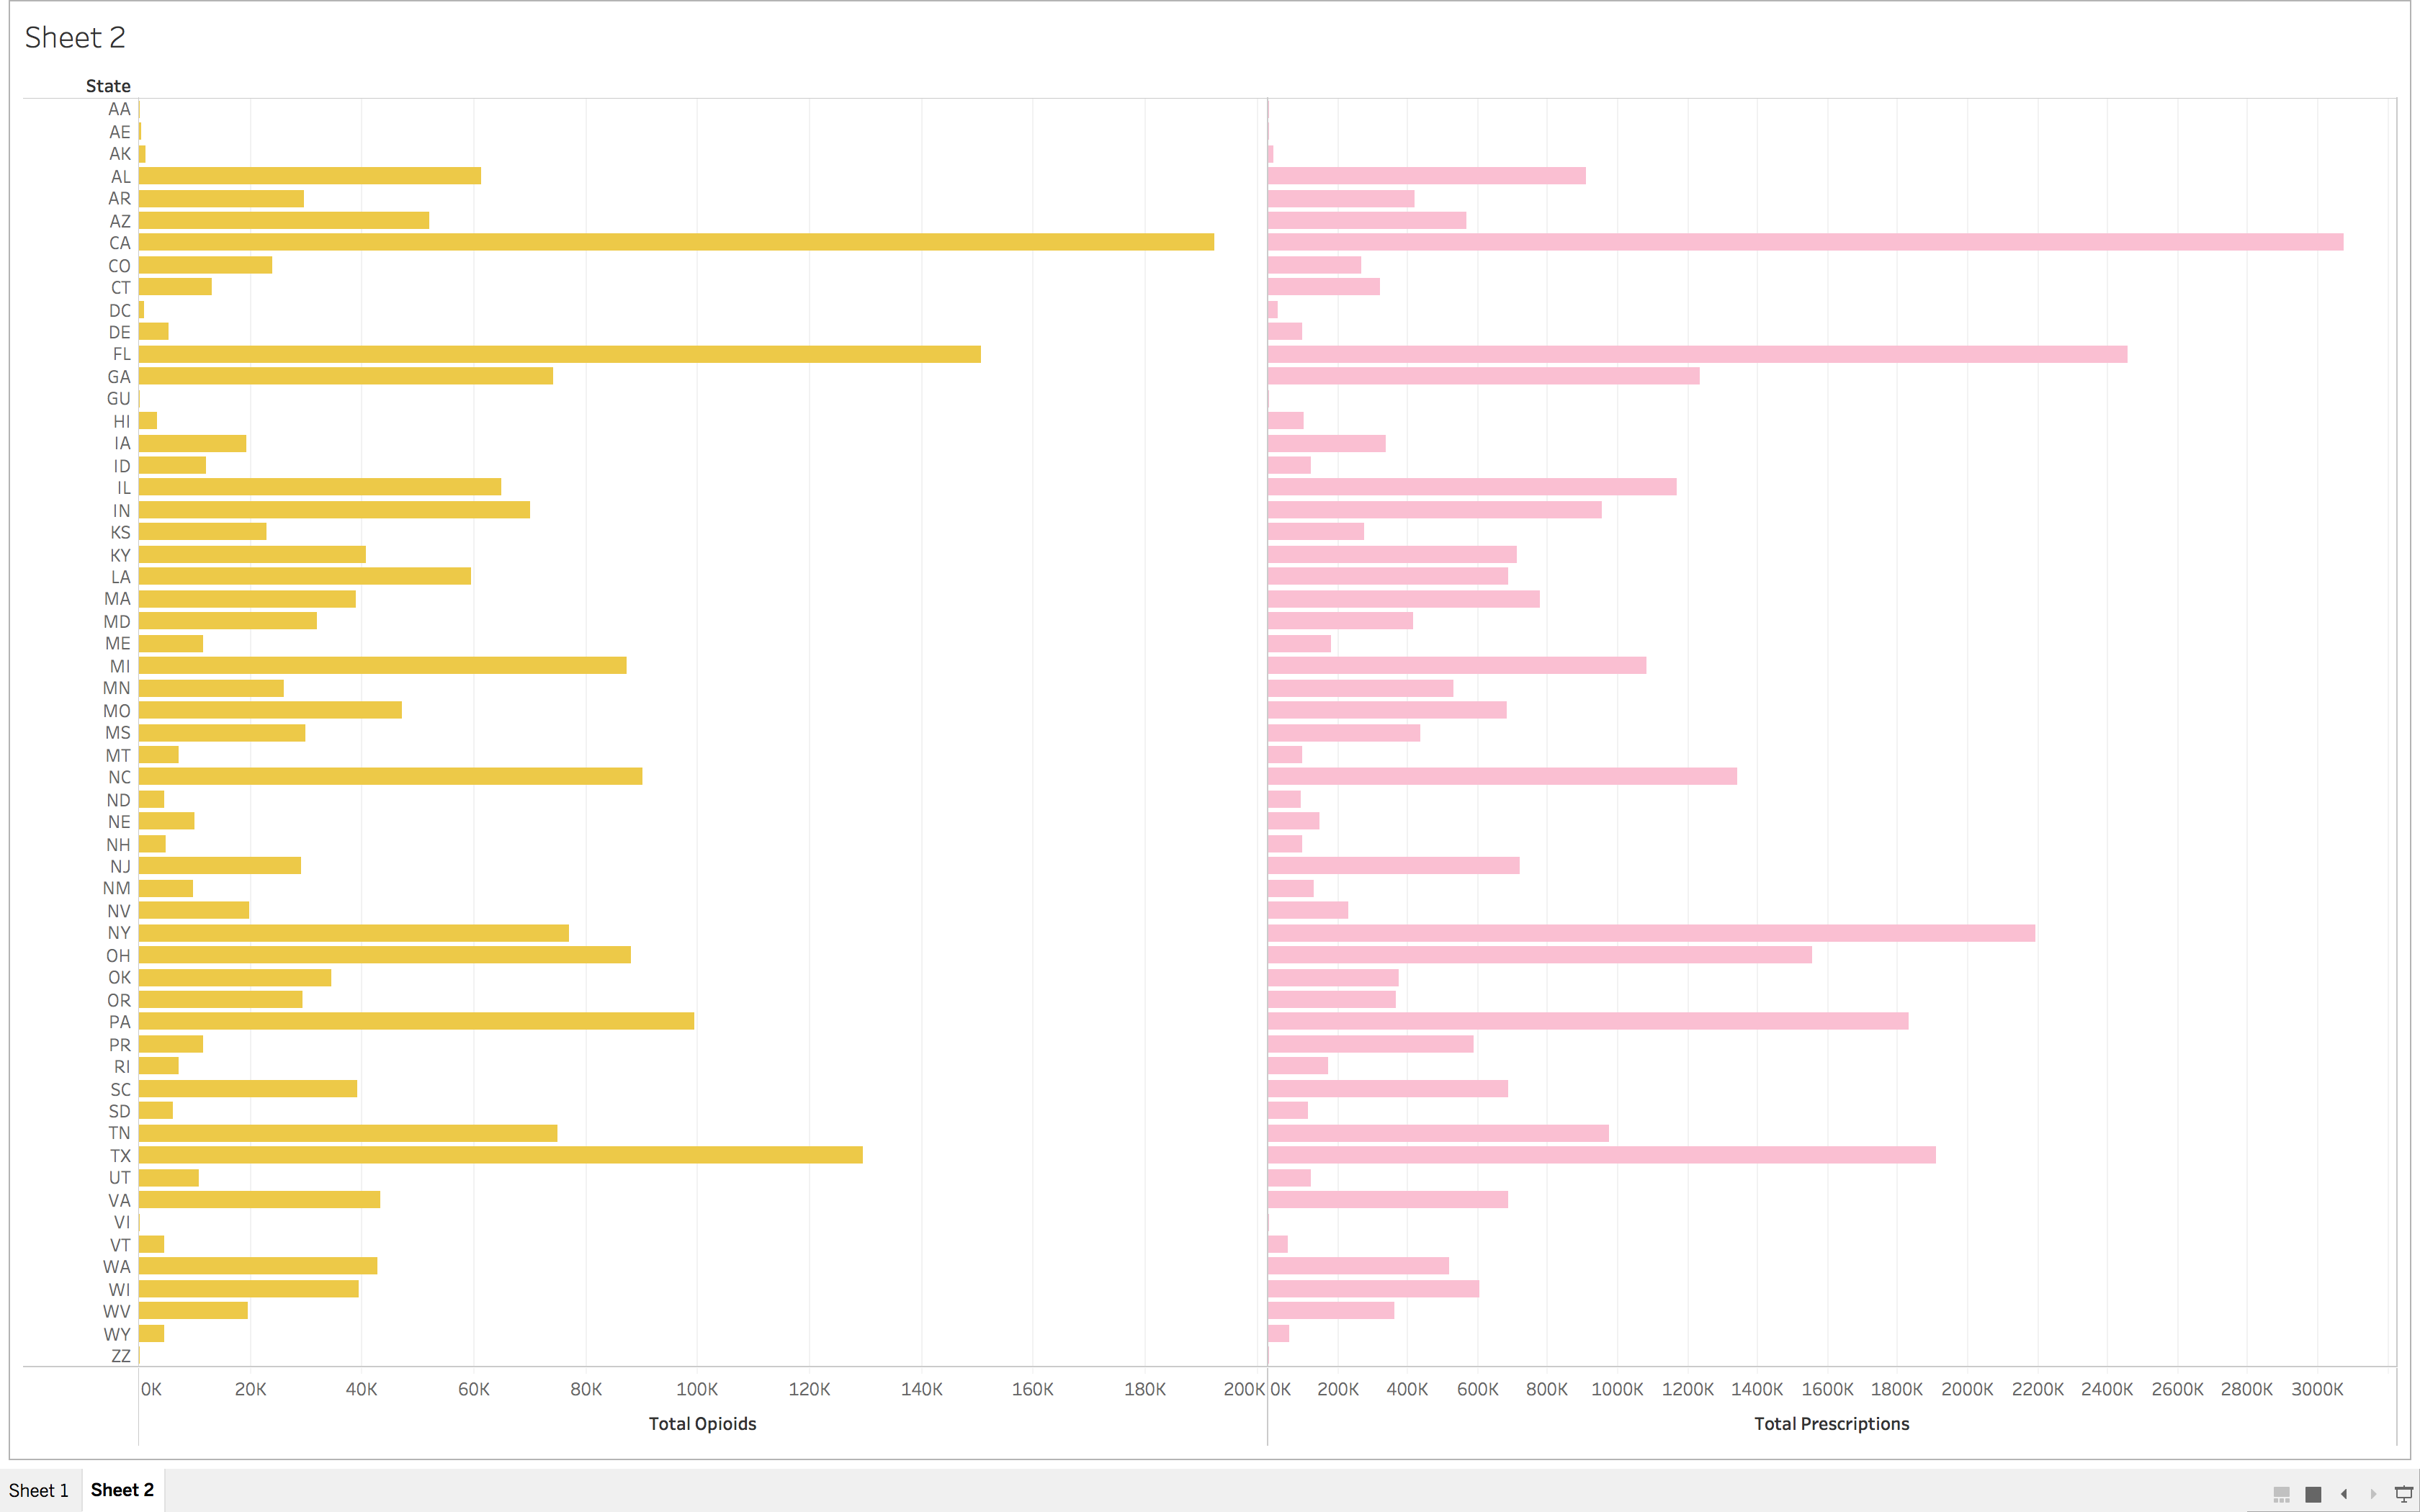

In [153]:
# When you get back - add deaths to the main dataframe! I think that's a necessary feature. 
# ADDED! 

prescribers_clean.to_csv('prescribers_clean.csv')

In [154]:
prescribers_clean.shape

(23937, 256)

In [155]:
 prescribers_clean.head()

,State,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,total_opioids,total_prescriptions,Abbrev,Deaths
0,TX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,17,47,TX,2601.0
1,TX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,144,TX,2601.0
2,TX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,17,35,TX,2601.0
3,TX,0,0,16,0,0,0,0,22,0,...,40,54,0,0,12,1,155,890,TX,2601.0
4,TX,0,23,0,0,0,0,0,12,0,...,0,0,0,0,0,1,132,1332,TX,2601.0


In [141]:
# Visualization of Deaths by State 

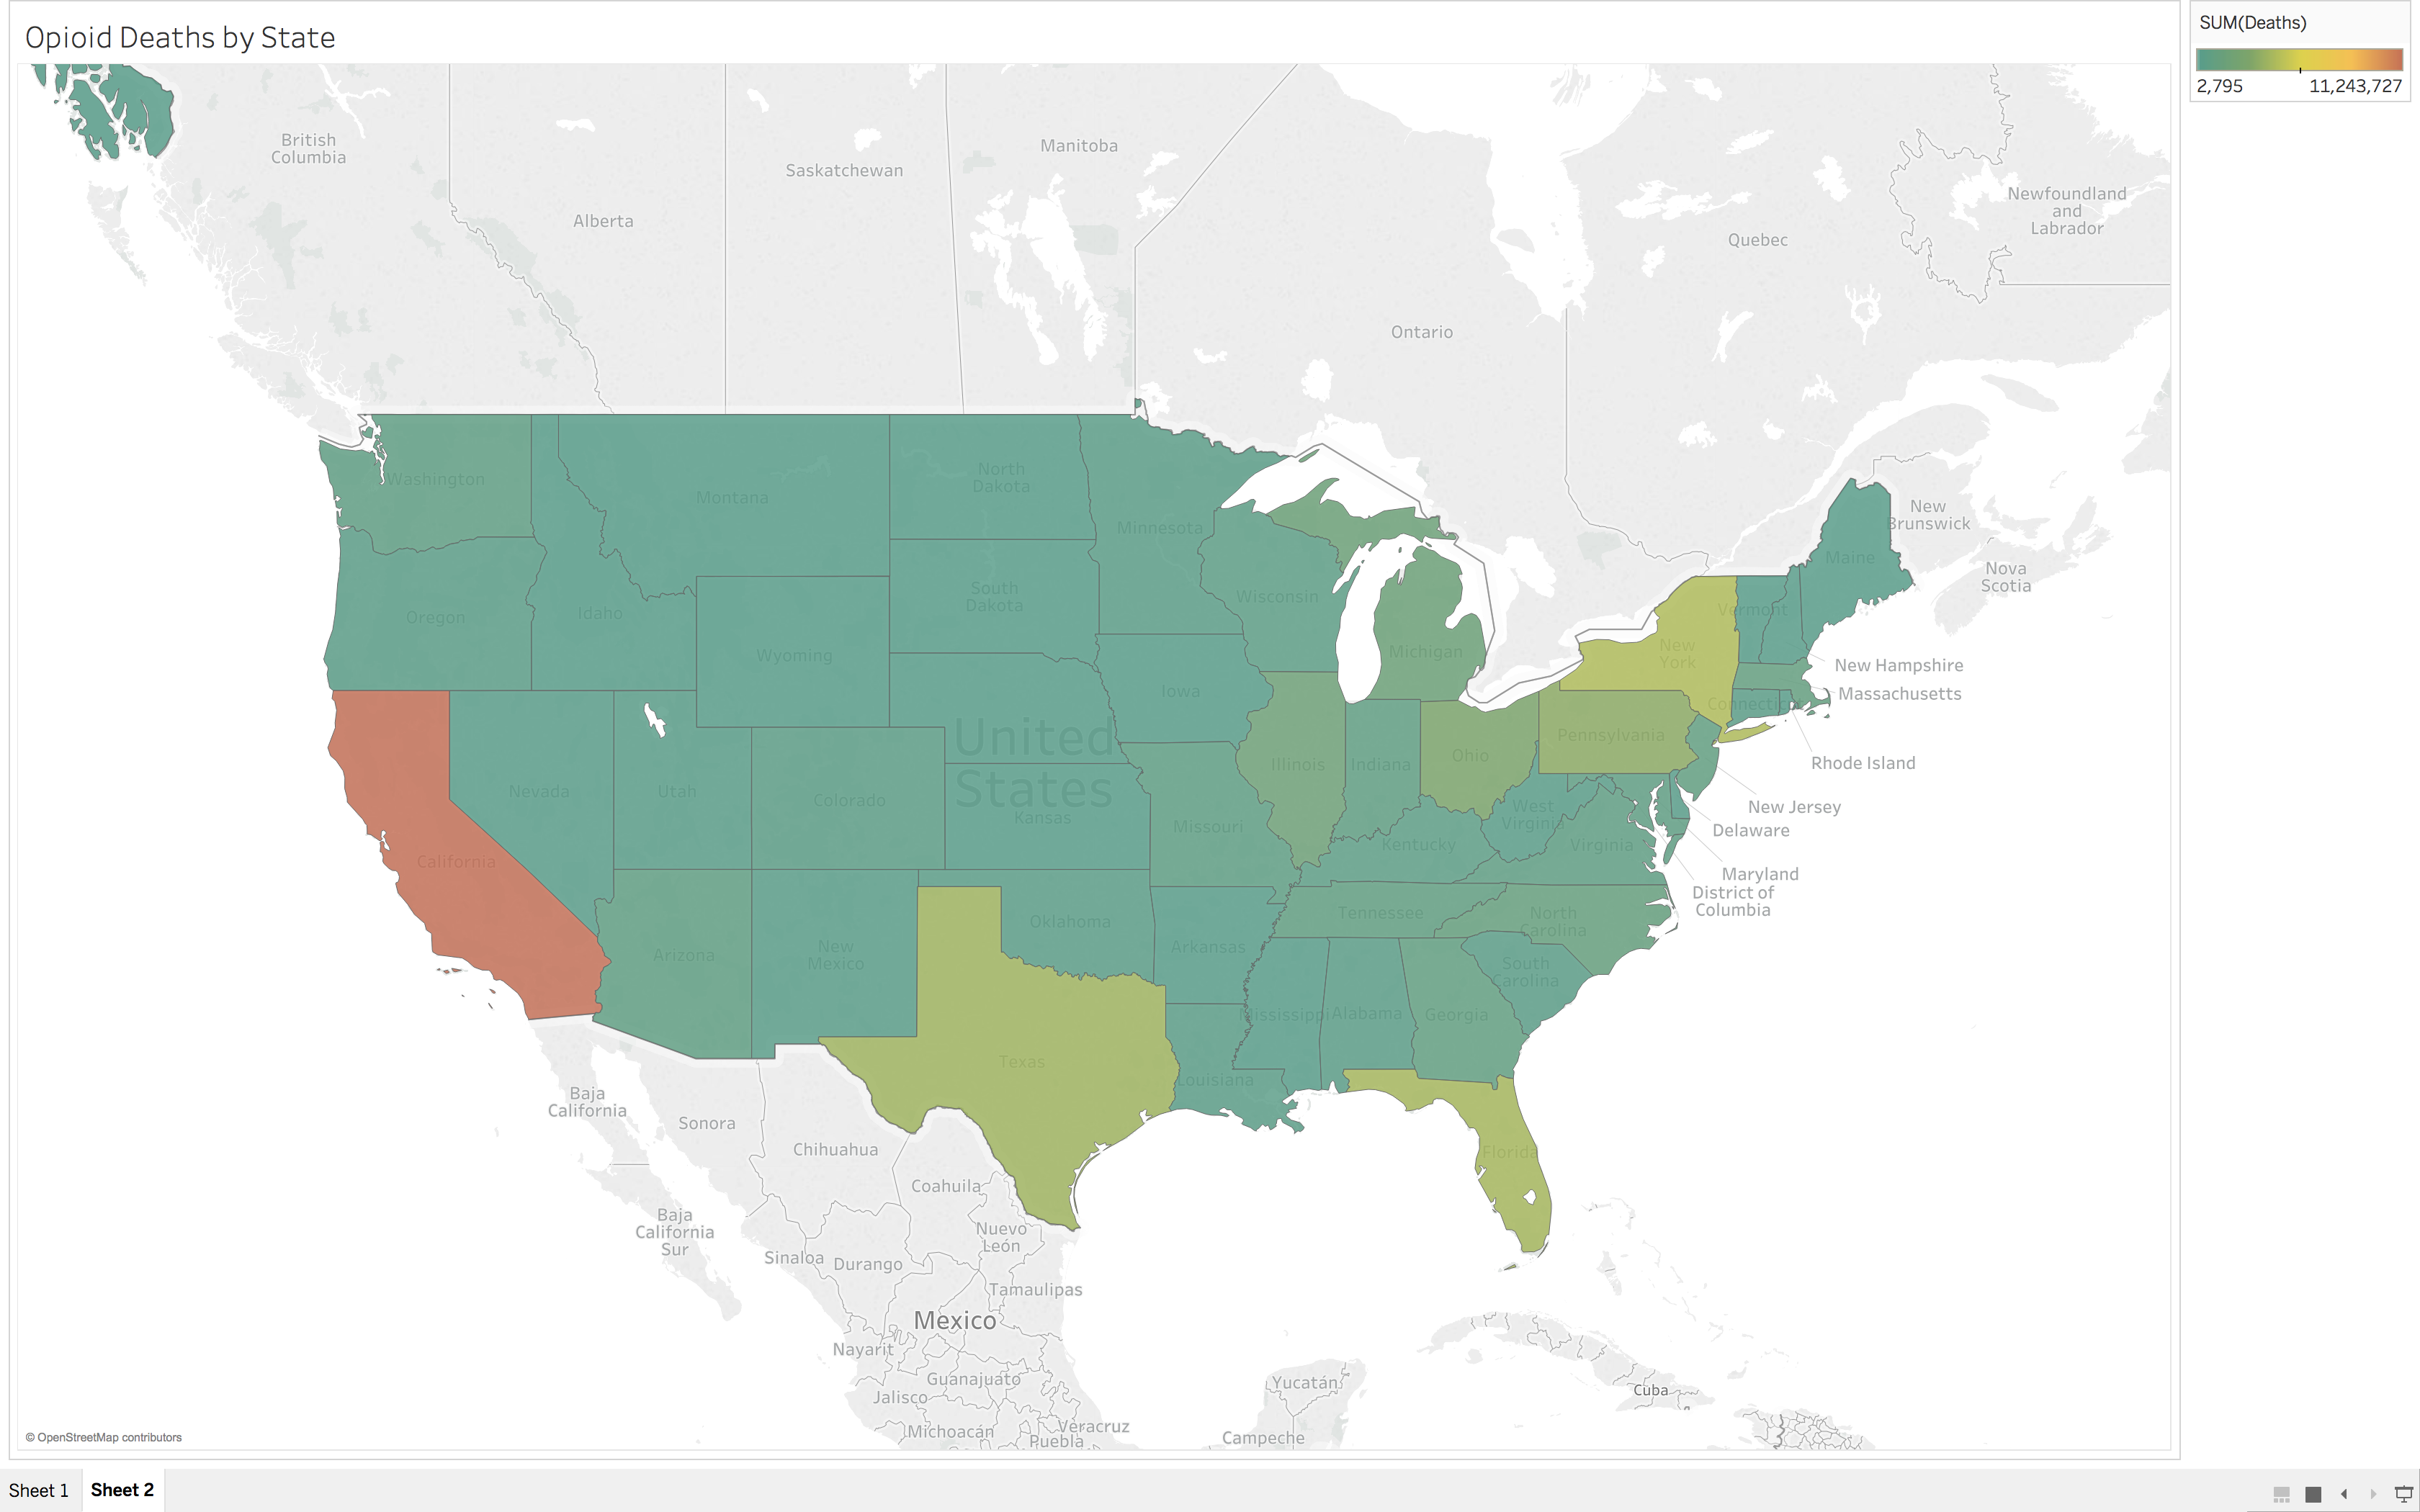